In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset
First, read the combined data from $2014$ until $2018$ from local disk.

In [2]:
data = pd.read_csv('./data/data_2014_2018.csv')
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,year
0,10400,10400,10400.0,36 months,6.99%,321.08,A,A3,Truck Driver Delivery Personel,8 years,...,0,0,179407,15030,13000,11325,N,Cash,N,2014
1,15000,15000,15000.0,60 months,12.39%,336.64,C,C1,MANAGEMENT,10+ years,...,0,0,196500,149140,10000,12000,N,Cash,N,2014
2,9600,9600,9600.0,36 months,13.66%,326.53,C,C3,Admin Specialist,10+ years,...,0,0,52490,38566,21100,24890,N,Cash,N,2014
3,7650,7650,7650.0,36 months,13.66%,260.20,C,C3,Technical Specialist,< 1 year,...,0,0,82331,64426,4900,64031,N,Cash,N,2014
4,21425,21425,21425.0,60 months,15.59%,516.36,D,D1,Programming Analysis Supervisor,6 years,...,0,0,57073,42315,15000,35573,N,Cash,N,2014


In [3]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642574 entries, 0 to 1642573
Columns: 88 entries, loan_amnt to year
dtypes: float64(25), int64(39), object(24)
memory usage: 1.1+ GB


# Data Cleaning

### 1. Features collected after loan is issued
For this problem, we will assume that our model will run at the moment one begins to apply for the loan. Thus, there should be no information about user's payment behaviors.

In [4]:
ongo_columns = ['funded_amnt', 'funded_amnt_inv', 'issue_d', 'pymnt_plan', 'out_prncp', 
                'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                'policy_code', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
                'last_credit_pull_d', 'disbursement_method']
data = data.drop(labels=ongo_columns, axis=1)

data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642574 entries, 0 to 1642573
Columns: 70 entries, loan_amnt to year
dtypes: float64(14), int64(37), object(19)
memory usage: 877.2+ MB


### 2. Parsing `loan_status`

In [5]:
data['loan_status'].value_counts()

Current               808178
Fully Paid            623342
Charged Off           173491
Late (31-120 days)     19438
In Grace Period        13526
Late (16-30 days)       4575
Default                   24
Name: loan_status, dtype: int64

There are a series of different kinds of loan status. Based on the explanation from [Lending Club](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-), The explanation for each status are listed below:

| Loan Status     | Explanation                                           |
| --------------- | ----------------------------------------------------- |
| Current         | Loan is up to date on all outstanding payments        |
| Fully Paid      | Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment                                                           |
| Default         | Loan has not been current for 121 days or more        |
| Charged Off     | Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance                          |
| In Grace Period | Loan is past due but within the 15-day grace period   |
| Late (16-30)    | Loan has not been current for 16 to 30 days           |
| Late (31-120)   | Loan has not been current for 31 to 120 days          |

For this project, we don't care about the loan that is in **Current** status. Instead, we are more interested in whether the loan is **Good** or **Bad**. Here, we assume loan in **Good** status if it will be fully paid, and the loan in **Bad** status if it is **Charged Off**, **Default**, or **Late (16-30 days, or 31-120 days)**. For loans that are in **Grace Period**, we will remove them from our data due to uncertainty.

In [6]:
# only keep the data that we are certainty about their final status
used_status = ['Charged Off', 'Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)', 'Default']
data = data[data['loan_status'].isin(used_status)]

In [7]:
# Encoding the `loan_status`
# status 1: 'Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Default'
# status 0: 'Fully Paid'
data['target'] = 1
data.loc[data['loan_status'] == 'Fully Paid', 'target'] = 0

data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820870 entries, 0 to 1642573
Columns: 71 entries, loan_amnt to target
dtypes: float64(14), int64(38), object(19)
memory usage: 450.9+ MB


### 3. Split into training and test dataset

After above procedures, we have reduced the dataset size from $1,642,574$ to $820,870$, and the features from $88$ to $70$.

In [8]:
# calculate the number of records for each year
year_count = data.groupby('year')['target'].count().reset_index()
year_count = year_count.rename(columns={'target': 'counts'})
year_count['ratio'] = year_count['counts'] / len(data)
year_count

,year,counts,ratio
0,2014,215210,0.262173
1,2015,302540,0.368560
2,2016,204393,0.248996
3,2017,92578,0.112780
4,2018,6149,0.007491


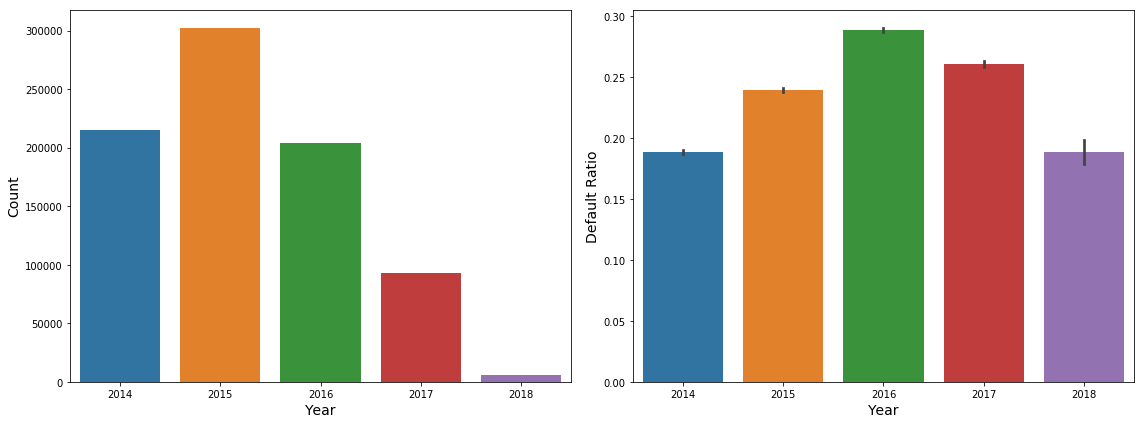

In [9]:
# visualize the time effect
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='year', data=data, ax=ax[0])
ax[0].set_xlabel('Year', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
sns.barplot(x='year', y='target', data=data, ax=ax[1])
ax[1].set_xlabel('Year', fontsize=14)
ax[1].set_ylabel('Default Ratio', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# drop useless features
data = data.drop(labels='loan_status', axis=1)

data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 820870 entries, 0 to 1642573
Columns: 70 entries, loan_amnt to target
dtypes: float64(14), int64(38), object(18)
memory usage: 484.7+ MB


Now, let's split the data into training and test set. Based on the above information, we decide to split the data according year information. More specifically, since the data after $2016$ accounts about $12\%$ of all the data, 
we will use the data from $2014$ until $2016$ as the training set, data from $2017$ until $2018$ as the test set.

In [11]:
# split into train and test set
train = data[data['year'] < 2017]
test = data[data['year'] >= 2017]

In [12]:
# save to disk
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

print('Training set:\t', train.shape, '\t', round(len(train) / len(data), 4))
print('Test set:\t', test.shape, '\t', round(len(test) / len(data), 4))

Training set:	 (722143, 70) 	 0.8797
Test set:	 (98727, 70) 	 0.1203
